In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
import cv2
import json
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
dir = "/content/drive/MyDrive/Downloads/glove"

data_yaml = f"{dir}/data.yaml"
train_dir = f"{dir}/train/images"
val_dir = f"{dir}/valid/images"
test_dir = f"{dir}/test/images"

output_dir = f"{dir}/output"
log_dir = f"{dir}/logs"

CONF_THRESHOLD = 0.4

In [ ]:
model = YOLO("yolov8n.pt")

model.train(data=data_yaml, epochs=20, imgsz=640, batch=16, project=dir, name="glove_model")

In [5]:
model = YOLO(f"{dir}/glove_model3/weights/best.pt")

In [23]:
import glob

SUBMISSION_PATH = f"{dir}/submission/Part_1_Glove_Detection"
OUTPUT_DIR = f"{SUBMISSION_PATH}/output"
LOGS_DIR = f"{SUBMISSION_PATH}/logs"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

best_model_path = f"{dir}/glove_model3/weights/best.pt"
model = YOLO(best_model_path)

image_files = []
image_files.extend(glob.glob(os.path.join(test_dir, "*.jpg")))

if not image_files:
    print(f"⚠️ No images found in {test_dir}. Please upload some single .jpg files there.")
else:
    print(f"Processing {len(image_files)} images...")

    for img_path in image_files:
        filename = os.path.basename(img_path)

        results = model(img_path, conf=CONF_THRESHOLD)
        result = results[0]

        log_entry = {"filename": filename, "detections": []}

        for box in result.boxes:
            coords = box.xyxy[0].tolist()
            log_entry["detections"].append({
                "label": result.names[int(box.cls[0])],
                "confidence": round(float(box.conf[0]), 2),
                "bbox": [round(c, 2) for c in coords]
            })

        # Save Log
        with open(os.path.join(LOGS_DIR, f"{os.path.splitext(filename)[0]}.json"), 'w') as f:
            json.dump(log_entry, f, indent=2)

        # Save Image
        cv2.imwrite(os.path.join(OUTPUT_DIR, filename), result.plot())

    print("✅ Processing complete!")

Processing 108 images...

image 1/1 /content/drive/MyDrive/Downloads/glove/test/images/wq116_jpg.rf.4acf428a2cc5a5b1ef4a4f454658283d.jpg: 640x640 1 glove, 306.5ms
Speed: 4.1ms preprocess, 306.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Downloads/glove/test/images/wq074_jpg.rf.0de714293f9933bf03a8923e642c56b2.jpg: 640x640 1 glove, 559.9ms
Speed: 5.8ms preprocess, 559.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Downloads/glove/test/images/IMG20220226195009_jpg.rf.4329f54093e4c5f5512504dd2081cab0.jpg: 640x640 1 no_glove, 369.0ms
Speed: 4.7ms preprocess, 369.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Downloads/glove/test/images/IMG20220227154258_jpg.rf.4a665d111b468e32053b850ef0003f2a.jpg: 640x640 1 no_glove, 350.1ms
Speed: 4.6ms preprocess, 350.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)



Comparing 5 Random Images (Original vs Detection):


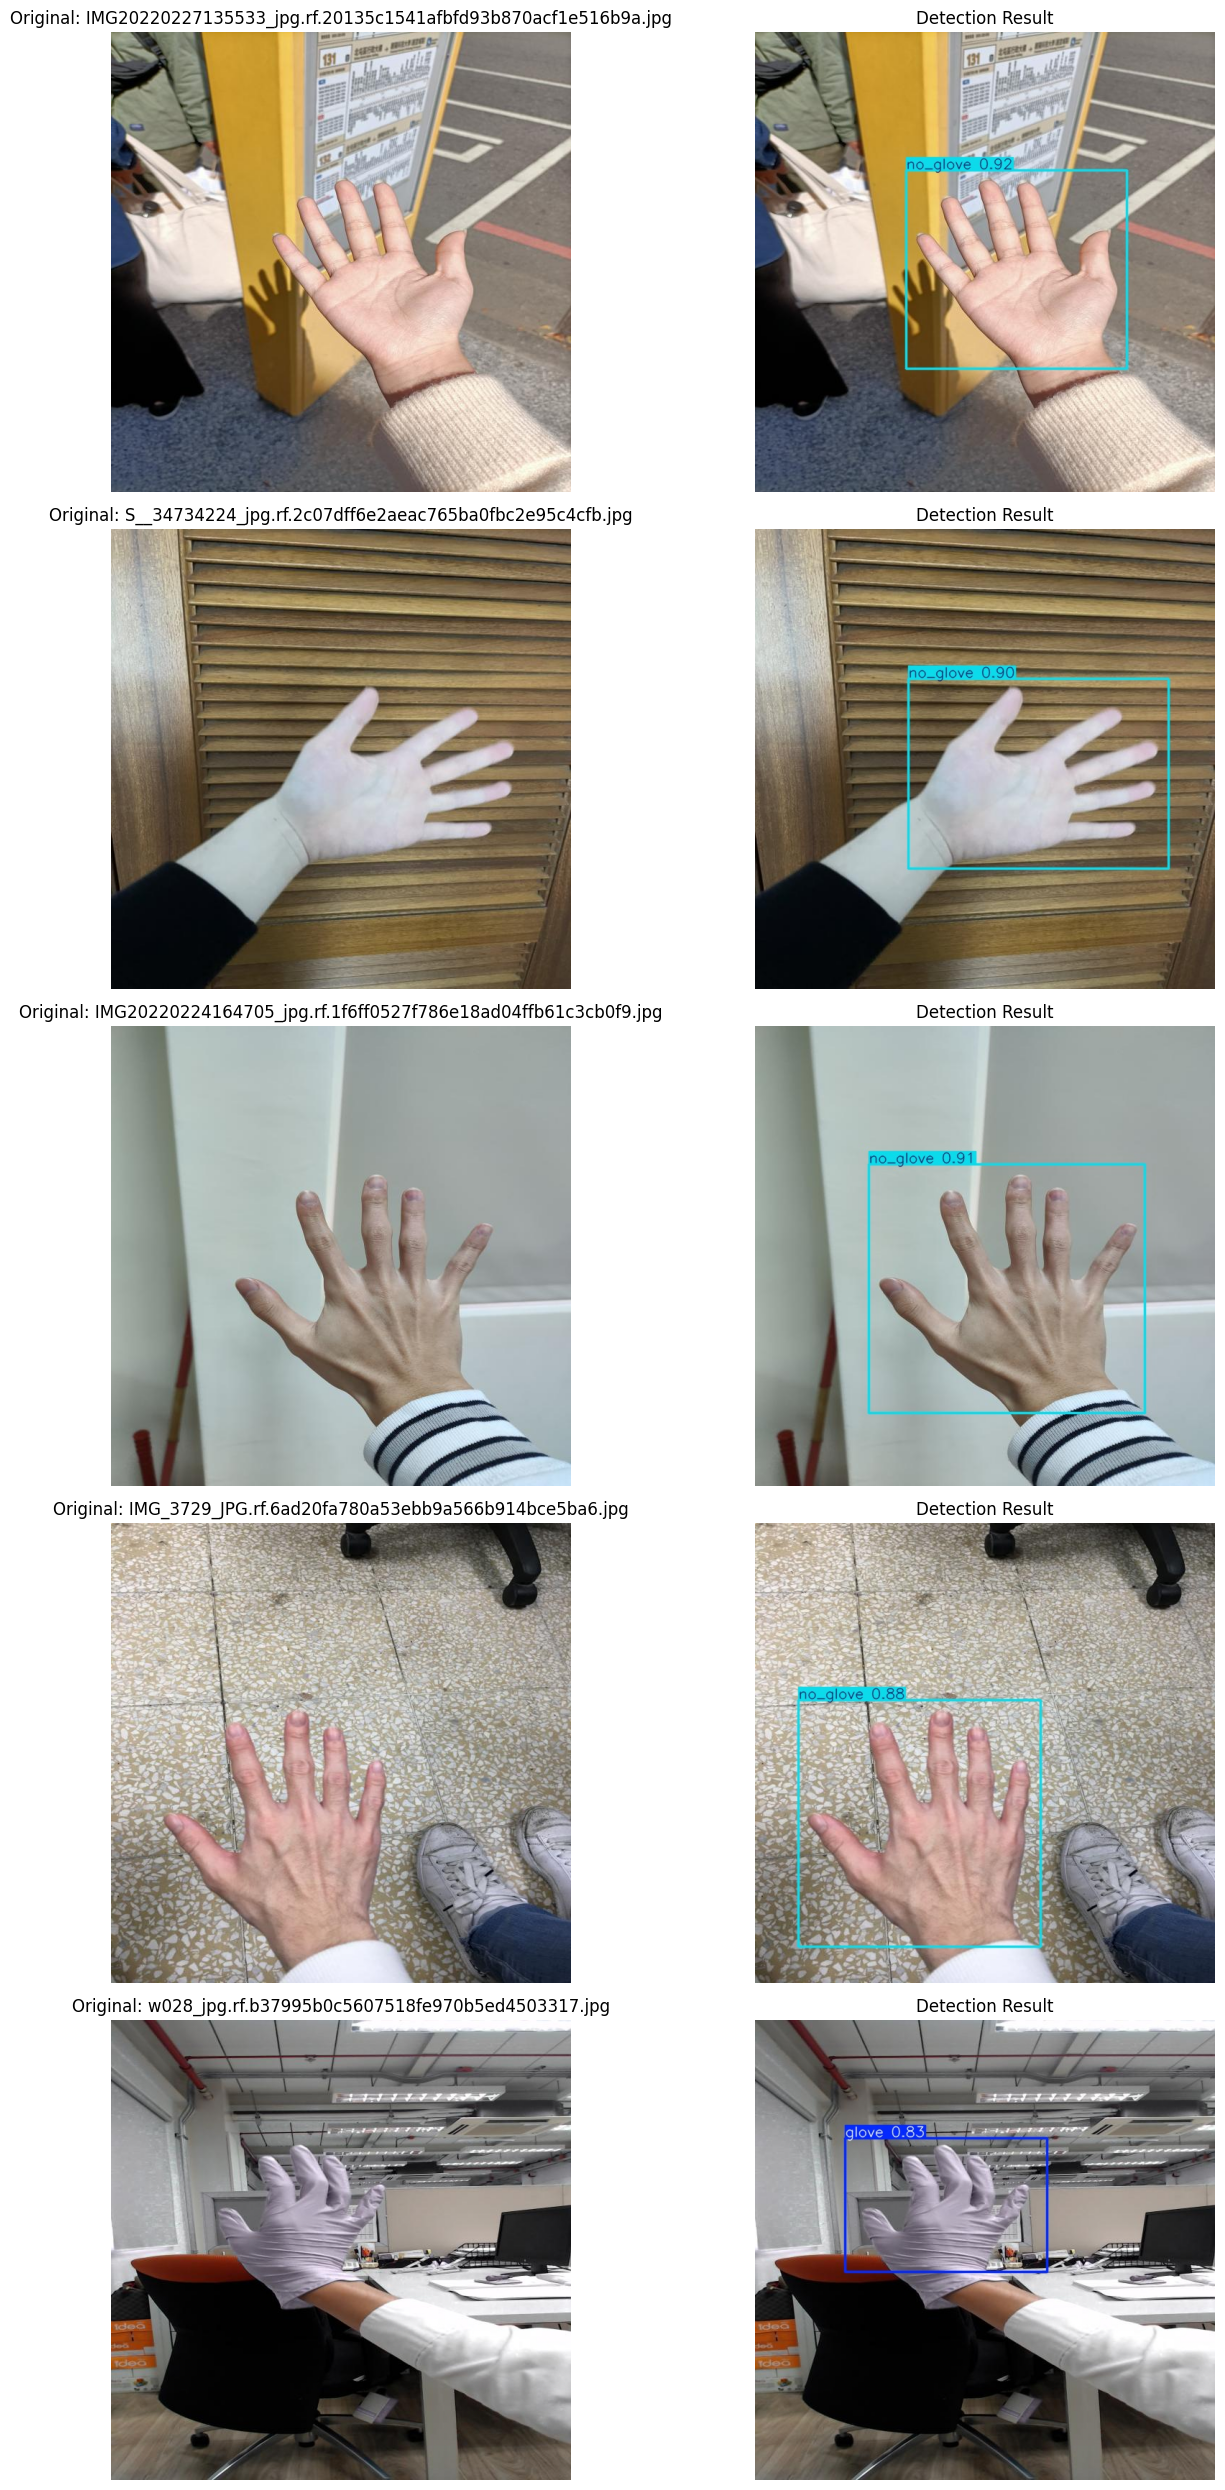

In [22]:
import matplotlib.pyplot as plt
import random

processed_files = glob.glob(os.path.join(OUTPUT_DIR, "*.jpg"))

if not processed_files:
    print("⚠️ No output images found. Make sure you ran the detection step first!")
else:
    num_to_show = min(5, len(processed_files))
    selected_files = random.sample(processed_files, num_to_show)

    print(f"Comparing {num_to_show} Random Images (Original vs Detection):")

    plt.figure(figsize=(15, 5 * num_to_show))

    for i, out_path in enumerate(selected_files):
        filename = os.path.basename(out_path)

        orig_path = os.path.join(test_dir, filename)

        img_orig = cv2.imread(orig_path)
        img_out = cv2.imread(out_path)

        if img_orig is not None:
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        if img_out is not None:
            img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

        plt.subplot(num_to_show, 2, 2*i + 1)
        if img_orig is not None:
            plt.imshow(img_orig)
            plt.title(f"Original: {filename}")
        else:
            plt.text(0.5, 0.5, "Original File Not Found", ha='center')
        plt.axis('off')

        plt.subplot(num_to_show, 2, 2*i + 2)
        if img_out is not None:
            plt.imshow(img_out)
            plt.title(f"Detection Result")
        else:
            plt.text(0.5, 0.5, "Output File Corrupted", ha='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()